test_initialize_lattice passed.
test_compute_neighbor_indices passed.
Calculated energy: 0, Expected energy: 0.0
test_calculate_interaction_energy passed.
test_attempt_move passed.


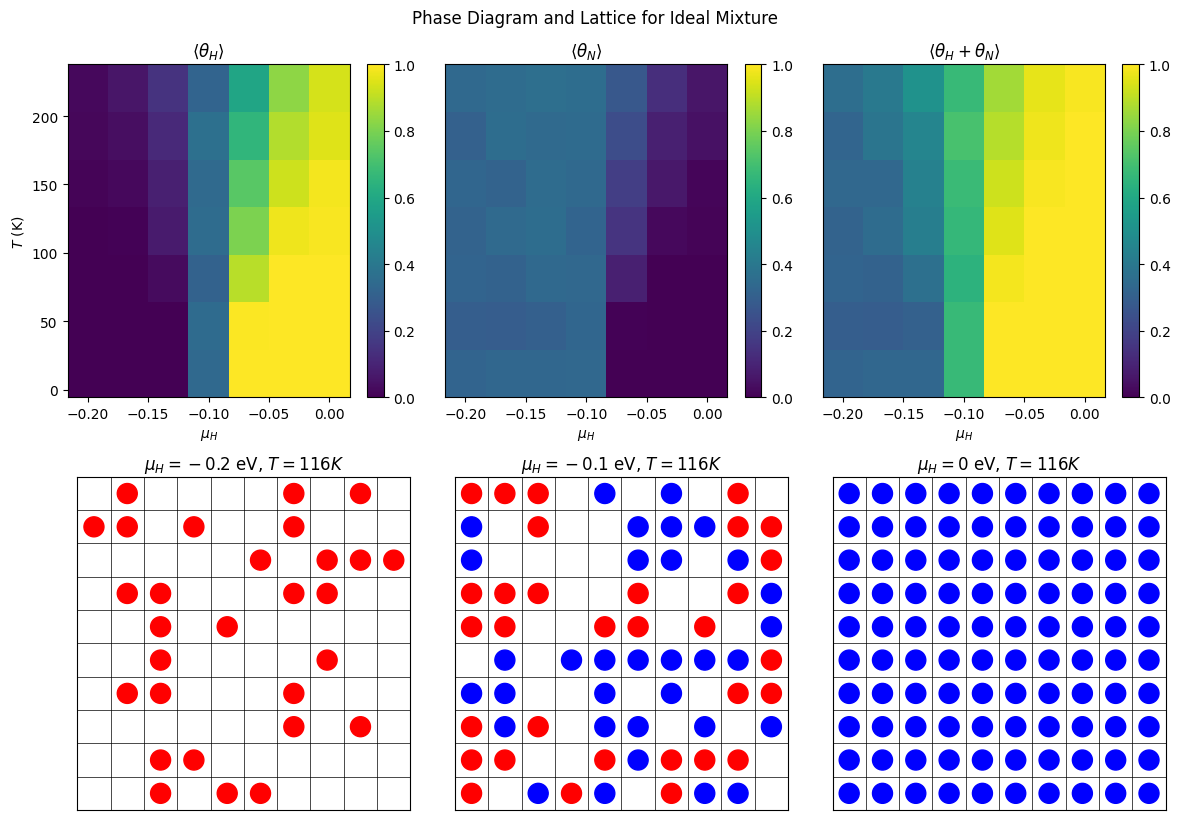

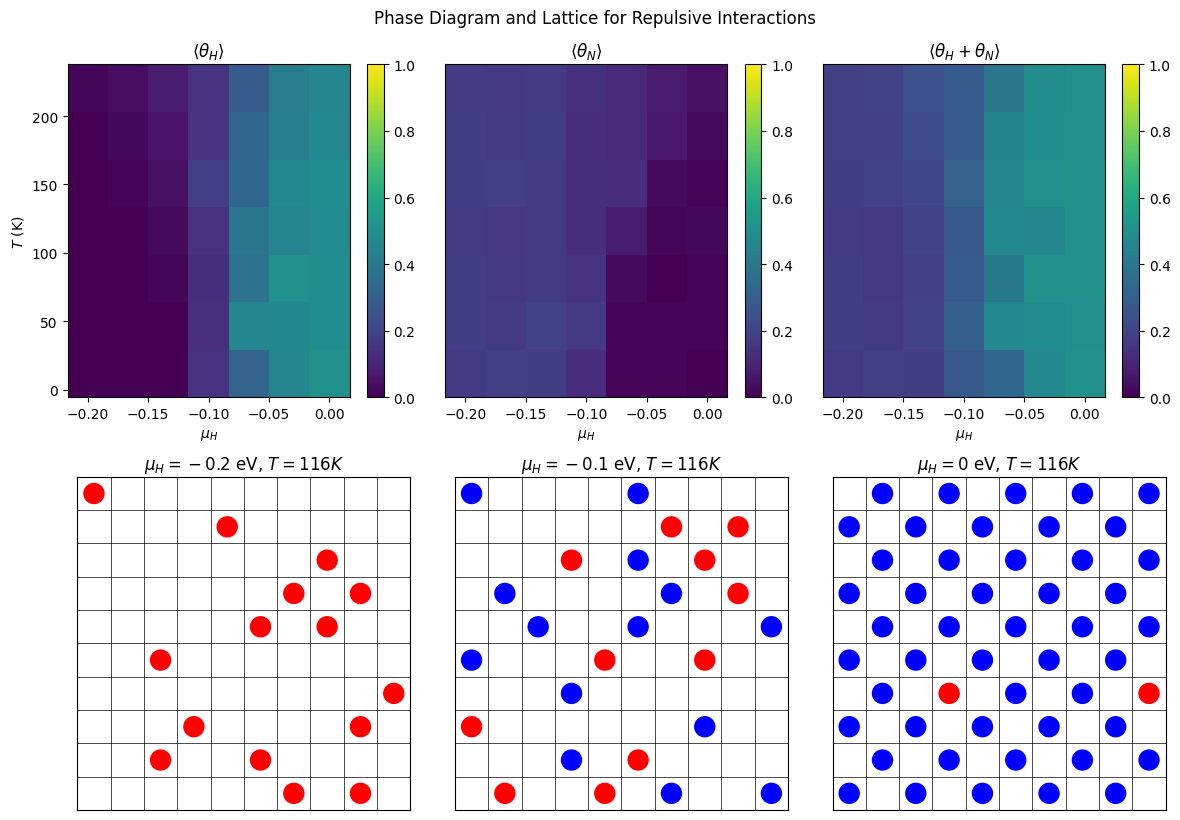

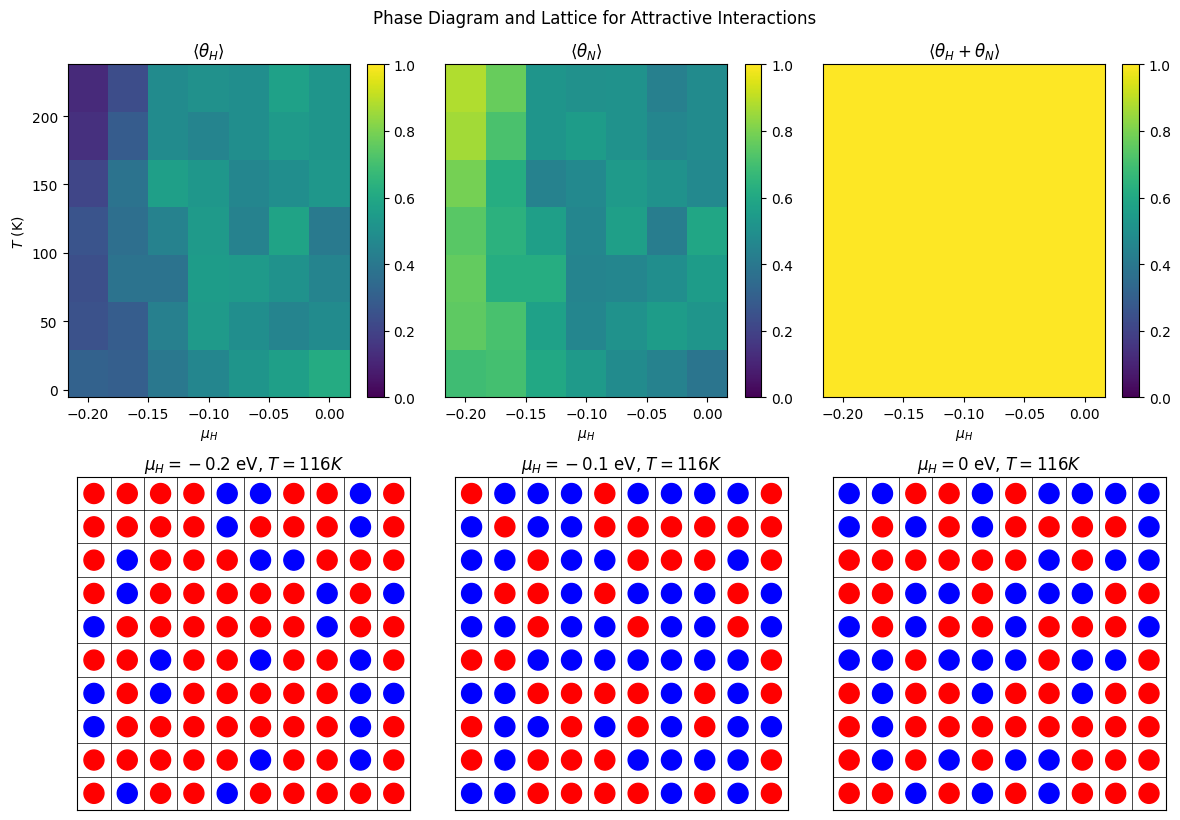

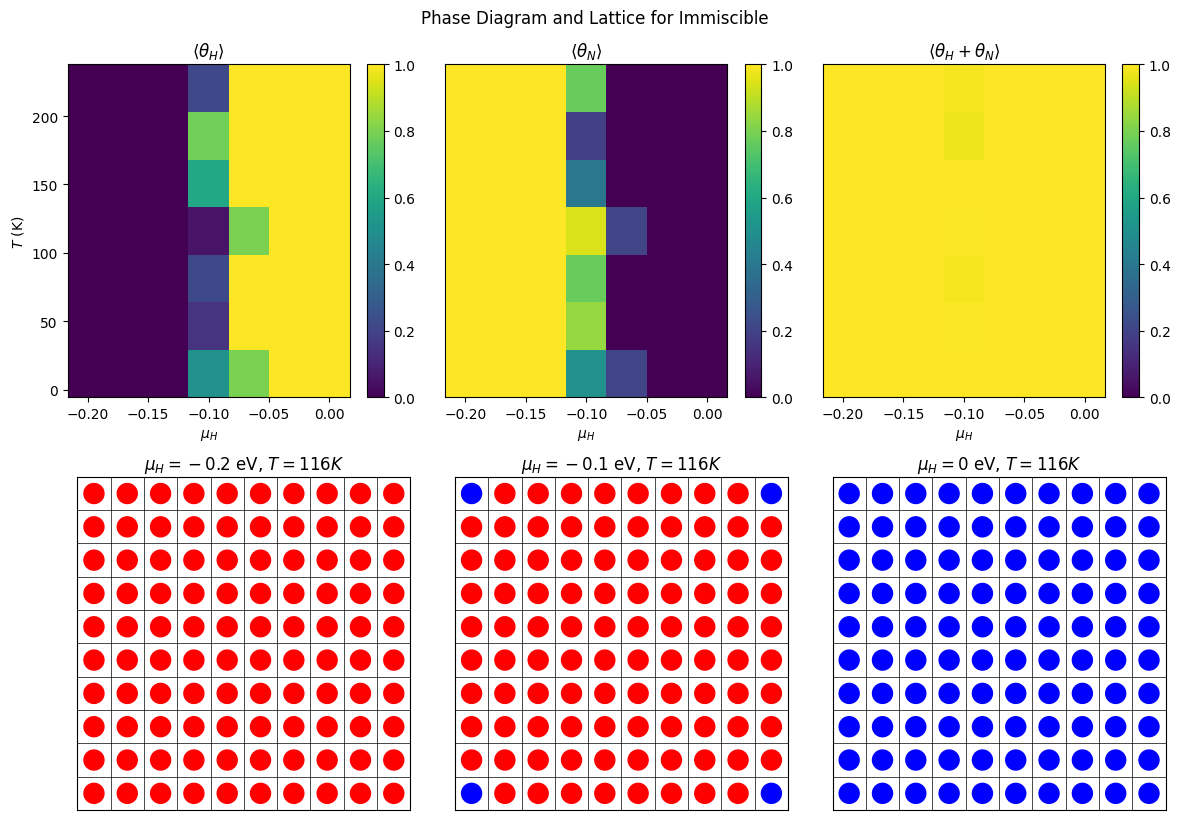

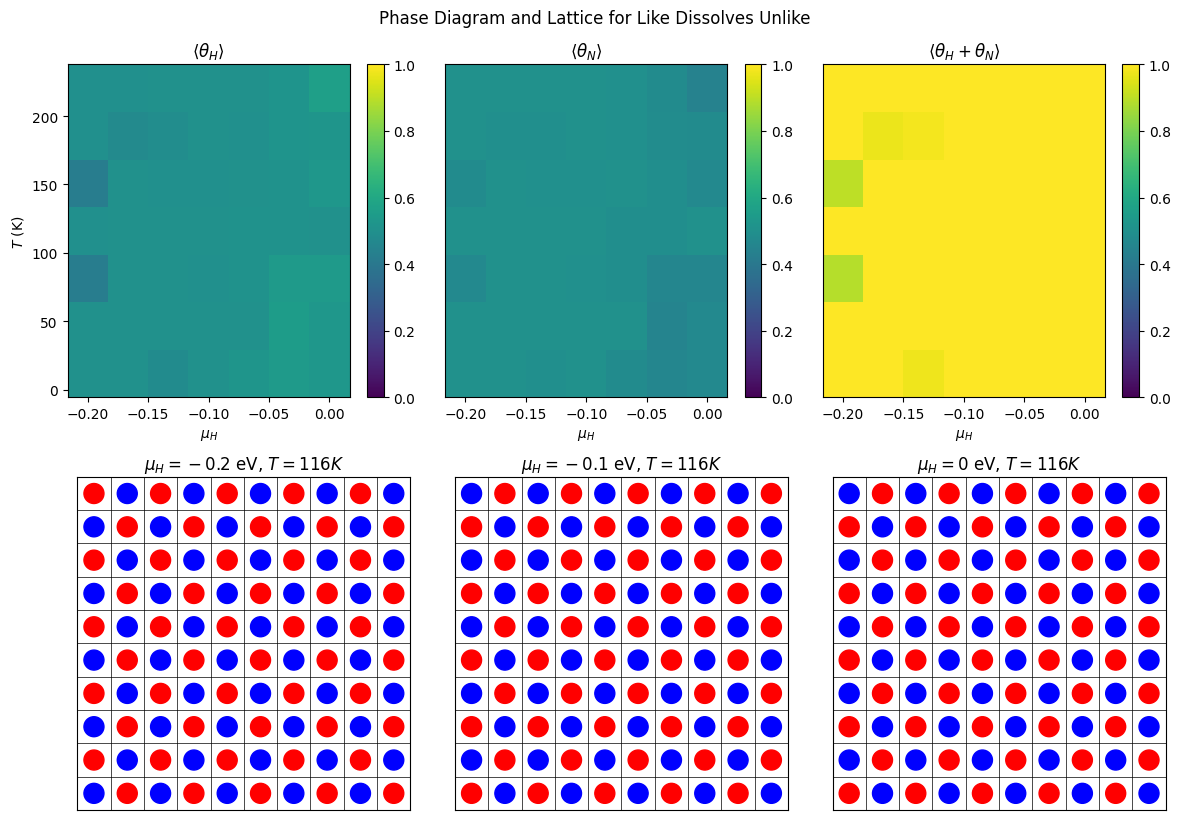

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
lattice_size = 10  # Lattice size (NxN)
n_steps = 10000
mus_H = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

# Convert T values to Kelvin (assuming T in eV/k_B, where k_B = 8.6173e-5 eV/K)
k_B = 8.6173e-5
Ts_kelvin = Ts / k_B

# Interaction parameters (eV)
interaction_sets = {
    "Ideal Mixture": [-0.1, -0.1, 0.0, 0.0, 0.0],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Repulsive Interactions": [-0.1, -0.1, 0.05, 0.05, 0.05],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Attractive Interactions": [-0.1, -0.1, -0.05, -0.05, -0.05],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Immiscible": [-0.1, -0.1, -0.05, -0.05, 0.05],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Like Dissolves Unlike": [-0.1, -0.1, 0.05, 0.05, -0.05]  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
}

# Function to initialize lattice
def initialize_lattice(size):
    lattice = np.zeros((size, size))  # 0 represents empty sites
    return lattice

# Testing snippet for lattice initialization
def test_initialize_lattice():
    lattice = initialize_lattice(5)
    assert lattice.shape == (5, 5), "Lattice size is incorrect"
    assert np.all(lattice == 0), "Lattice is not properly initialized with empty sites"
    print("test_initialize_lattice passed.")

# Function to compute neighbor indices
def compute_neighbor_indices(size):
    neighbor_indices = {}
    for x in range(size):
        for y in range(size):
            neighbors = [
                ((x - 1) % size, y),
                ((x + 1) % size, y),
                (x, (y - 1) % size),
                (x, (y + 1) % size)
            ]
            neighbor_indices[(x, y)] = neighbors
    return neighbor_indices

# Testing snippet for neighbor calculation
def test_compute_neighbor_indices():
    neighbor_indices = compute_neighbor_indices(3)
    assert len(neighbor_indices) == 9, "Neighbor indices dictionary size is incorrect"
    assert neighbor_indices[(0, 0)] == [(2, 0), (1, 0), (0, 2), (0, 1)], "Neighbor indices calculation is incorrect"
    print("test_compute_neighbor_indices passed.")

# Function to calculate interaction energy
def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_HH, epsilon_NN, epsilon_NH):
    x, y = site
    interaction_energy = 0
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        if neighbor_particle != 0:
            if particle == 1:  # Particle H
                if neighbor_particle == 1:
                    interaction_energy += epsilon_HH
                else:
                    interaction_energy += epsilon_NH
            else:  # Particle H
                if neighbor_particle == 2:
                    interaction_energy += epsilon_NN
                else:
                    interaction_energy += epsilon_NH
    return interaction_energy

# Testing snippet for interaction energy calculation
def test_calculate_interaction_energy():
    lattice = np.array([[1, 0, 2], [0, 1, 0], [2, 0, 0]])
    neighbor_indices = compute_neighbor_indices(3)
    epsilon_NN, epsilon_HH, epsilon_NH = -0.05, -0.05, 0.05
    
    # Calculate expected energy manually
    # The central particle (1, 1) is of type N (1)
    # It has neighbors at (0, 1), (2, 1), (1, 0), (1, 2)
    # Neighbors: (0, 1) is empty, (2, 1) is empty, (1, 0) is empty, (1, 2) is empty
    # Only non-zero neighbors are at (0, 0) and (2, 0), which are types 1 and 2 respectively
    expected_energy = epsilon_NN + epsilon_NH  # -0.05 + 0.05 = 0.0
    
    energy = calculate_interaction_energy(lattice, (1, 1), 1, neighbor_indices, epsilon_NN, epsilon_HH, epsilon_NH)
    print(f"Calculated energy: {energy}, Expected energy: {expected_energy}")
    assert np.isclose(energy, expected_energy), "Interaction energy calculation is incorrect"
    print("test_calculate_interaction_energy passed.")

# Function to attempt a Monte Carlo move
def attempt_move(lattice, N_H, N_N, H_empty, neighbor_indices, params):
    size = lattice.shape[0]
    H_sites = size * size
    beta = 1 / params['T']
    epsilon_H, epsilon_N, epsilon_HH, epsilon_NN, epsilon_NH, mu_H, mu_N = (
        params['epsilon_H'], params['epsilon_N'], params['epsilon_HH'],
        params['epsilon_NN'], params['epsilon_NH'], params['mu_H'], params['mu_N']
    )

    if random.random() < 0.5:  # Attempt to add a particle
        if H_empty == 0:
            return N_H, N_N, H_empty
        site = random.choice(np.argwhere(lattice == 0))
        particle = random.choice([1, 2])
        if particle == 1:
            mu = mu_H
            epsilon = epsilon_H
            N_s = N_H
        else:
            mu = mu_N
            epsilon = epsilon_N
            N_s = N_N
        delta_E = epsilon + calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_HH, epsilon_NN, epsilon_NH)
        acc_prob = min(1, (H_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = particle
            if particle == 1:
                N_H += 1
            else:
                N_N += 1
            H_empty -= 1
    else:  # Removing a particle
        if H_sites - H_empty == 0:
            return N_H, N_N, H_empty
        site = random.choice(np.argwhere(lattice != 0))
        particle = lattice[tuple(site)]
        if particle == 1:
            mu = mu_H
            epsilon = epsilon_H
            N_s = N_H
        else:
            mu = mu_N
            epsilon = epsilon_N
            N_s = N_N
        delta_E = -epsilon - calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_HH, epsilon_NN, epsilon_NH)
        acc_prob = min(1, (N_s / (H_empty + 1)) * np.exp(-beta * (delta_E + mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = 0
            if particle == 1:
                N_H -= 1
            else:
                N_N -= 1
            H_empty += 1
    return N_H, N_N, H_empty

# Testing snippet for Monte Carlo move attempt
def test_attempt_move():
    lattice = initialize_lattice(3)
    neighbor_indices = compute_neighbor_indices(3)
    params = {
        'epsilon_N': -0.1, 'epsilon_H': -0.1, 'epsilon_NN': 0.0,
        'epsilon_HH': 0.0, 'epsilon_NH': 0.0, 'mu_N': -0.05, 'mu_H': -0.05, 'T': 0.01
    }
    N_N, N_H, N_empty = 0, 0, 9
    N_N, N_H, N_empty = attempt_move(lattice, N_N, N_H, N_empty, neighbor_indices, params)
    assert N_N + N_H + N_empty == 9, "Total number of lattice sites changed incorrectly"
    print("test_attempt_move passed.")

# Run all tests
test_initialize_lattice()
test_compute_neighbor_indices()
test_calculate_interaction_energy()
test_attempt_move()

# Function to run the simulation
def run_simulation(size, n_steps, params):
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    H_sites = size * size
    N_H, N_N, H_empty = 0, 0, H_sites
    coverage_H = np.zeros(n_steps)
    coverage_N = np.zeros(n_steps)

    for step in range(n_steps):
        N_H, N_N, H_empty = attempt_move(lattice, N_H, N_N, H_empty, neighbor_indices, params)
        coverage_H[step] = N_H / H_sites
        coverage_N[step] = N_N / H_sites

    return lattice, coverage_H, coverage_N

# Function to plot lattice configuration
def plot_lattice(ax, lattice, title):
    size = lattice.shape[0]
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    # Plot lattice as circles
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1:
                ax.add_patch(plt.Circle((y, x), 0.3, color='blue'))
            elif lattice[x, y] == 2:
                ax.add_patch(plt.Circle((y, x), 0.3, color='red'))
    # Add grid lines
    for x in range(size + 1):
        ax.plot([x - 0.5, x - 0.5], [-0.5, size - 0.5], color='black', lw=0.5)
    for y in range(size + 1):
        ax.plot([-0.5, size - 0.5], [y - 0.5, y - 0.5], color='black', lw=0.5)
    ax.set_xlim(-0.5, size - 0.5)
    ax.set_ylim(-0.5, size - 0.5)
    ax.set_aspect('equal')

# Run the simulation
np.random.seed(42)

final_lattice = np.zeros((len(mus_H), len(Ts), lattice_size, lattice_size))
mean_coverage_H = np.zeros((len(mus_H), len(Ts)))
mean_coverage_N = np.zeros((len(mus_H), len(Ts)))

for interaction_name, interaction_params in interaction_sets.items():
    for i, mu_H in enumerate(mus_H):
        for j, T in enumerate(Ts):
            params = {
                'epsilon_H': interaction_params[0],
                'epsilon_N': interaction_params[1],
                'epsilon_HH': interaction_params[2],
                'epsilon_NN': interaction_params[3],
                'epsilon_NH': interaction_params[4],
                'mu_H': mu_H,
                'mu_N': -0.1,
                'T': T
            }
            lattice, coverage_H, coverage_N = run_simulation(lattice_size, n_steps, params)
            final_lattice[i, j] = lattice
            mean_coverage_H[i, j] = np.mean(coverage_H[-1000:])
            mean_coverage_N[i, j] = np.mean(coverage_N[-1000:])

    # Plot the T-mu_H phase diagram
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.ravel()

    # Mean coverage of H
    cax1 = axs[0].pcolormesh(mus_H, Ts_kelvin, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title(r'$\langle \theta_H \rangle$')
    axs[0].set_xlabel(r'$\mu_H$')
    axs[0].set_ylabel(r'$T$ (K)')
    fig.colorbar(cax1, ax=axs[0])

    # Mean coverage of N
    cax2 = axs[1].pcolormesh(mus_H, Ts_kelvin, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title(r'$\langle \theta_N \rangle$')
    axs[1].set_xlabel(r'$\mu_H$')
    axs[1].set_yticks([])
    fig.colorbar(cax2, ax=axs[1])

    # Mean total coverage
    cax3 = axs[2].pcolormesh(mus_H, Ts_kelvin, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
    axs[2].set_xlabel(r'$\mu_H$')
    axs[2].set_yticks([])
    fig.colorbar(cax3, ax=axs[2])

    # Plot the final lattice configuration as circles
    plot_indices = [(0, 3), (3, 3), (6, 3)]  # (mu_H index, T index)
    plot_titles = [r'$\mu_H = -0.2$ eV, $T = 116 K$', r'$\mu_H = -0.1$ eV, $T = 116 K$', r'$\mu_H = 0$ eV, $T = 116 K$']

    for idx, (mu_idx, T_idx) in enumerate(plot_indices):
        ax = axs[3 + idx]
        lattice_plot = final_lattice[mu_idx, T_idx]
        plot_lattice(ax, lattice_plot, plot_titles[idx])

    plt.tight_layout()
    plt.suptitle(f"Phase Diagram and Lattice for {interaction_name}", y=1.02)
    plt.show()

test_initialize_lattice passed.
test_compute_neighbor_indices passed.
Calculated energy: 0, Expected energy: 0.0
test_calculate_interaction_energy passed.
test_attempt_move passed.


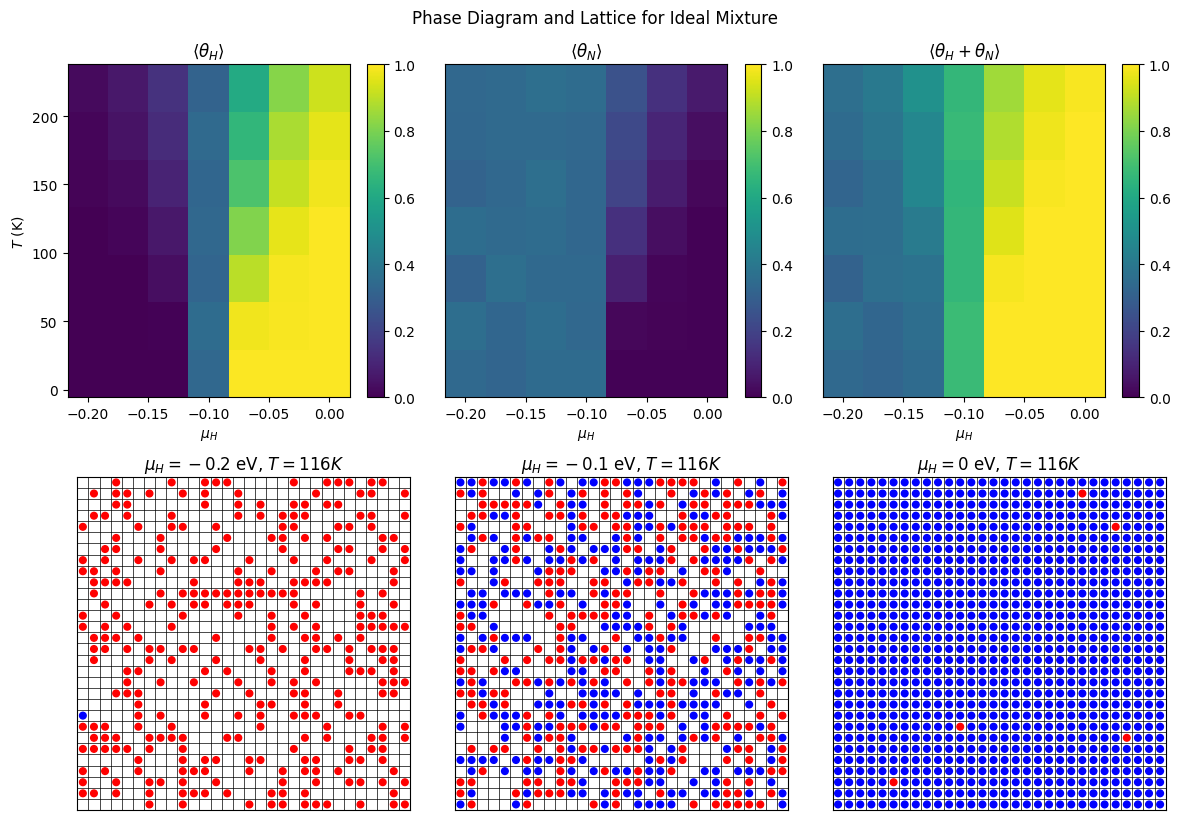

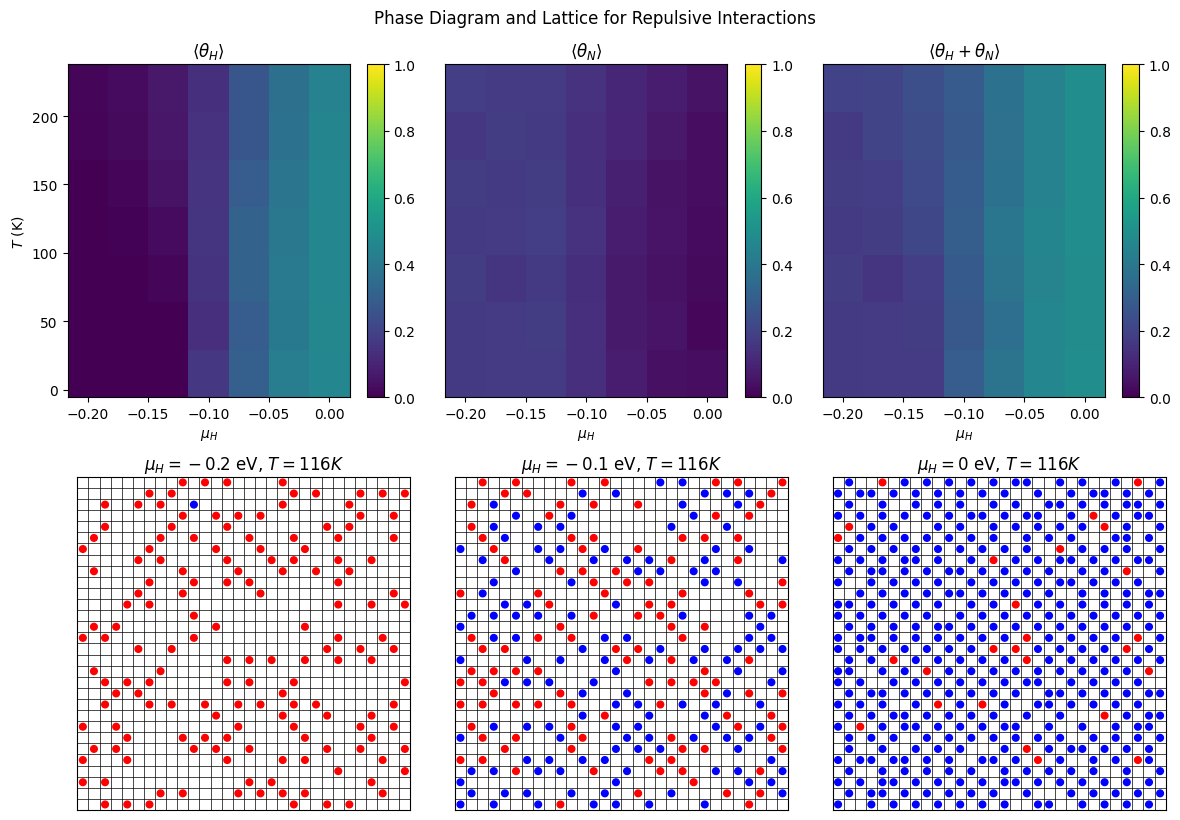

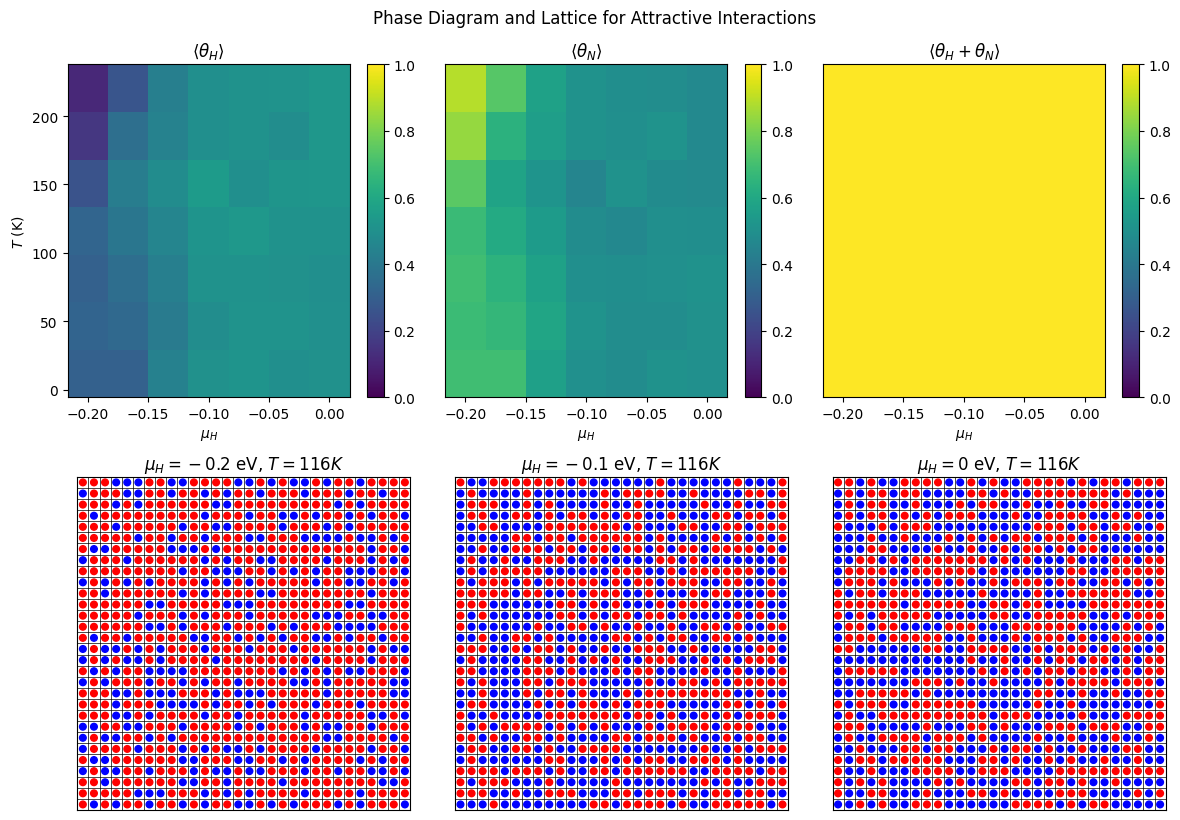

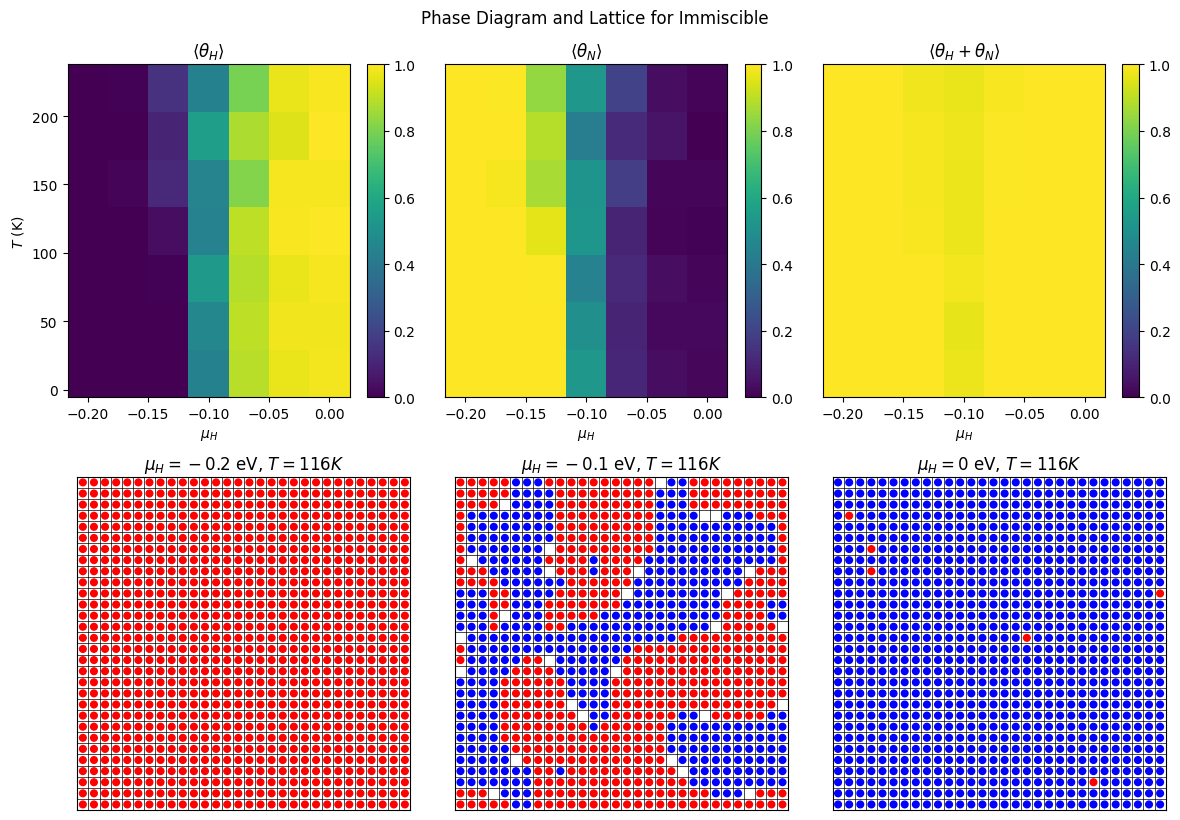

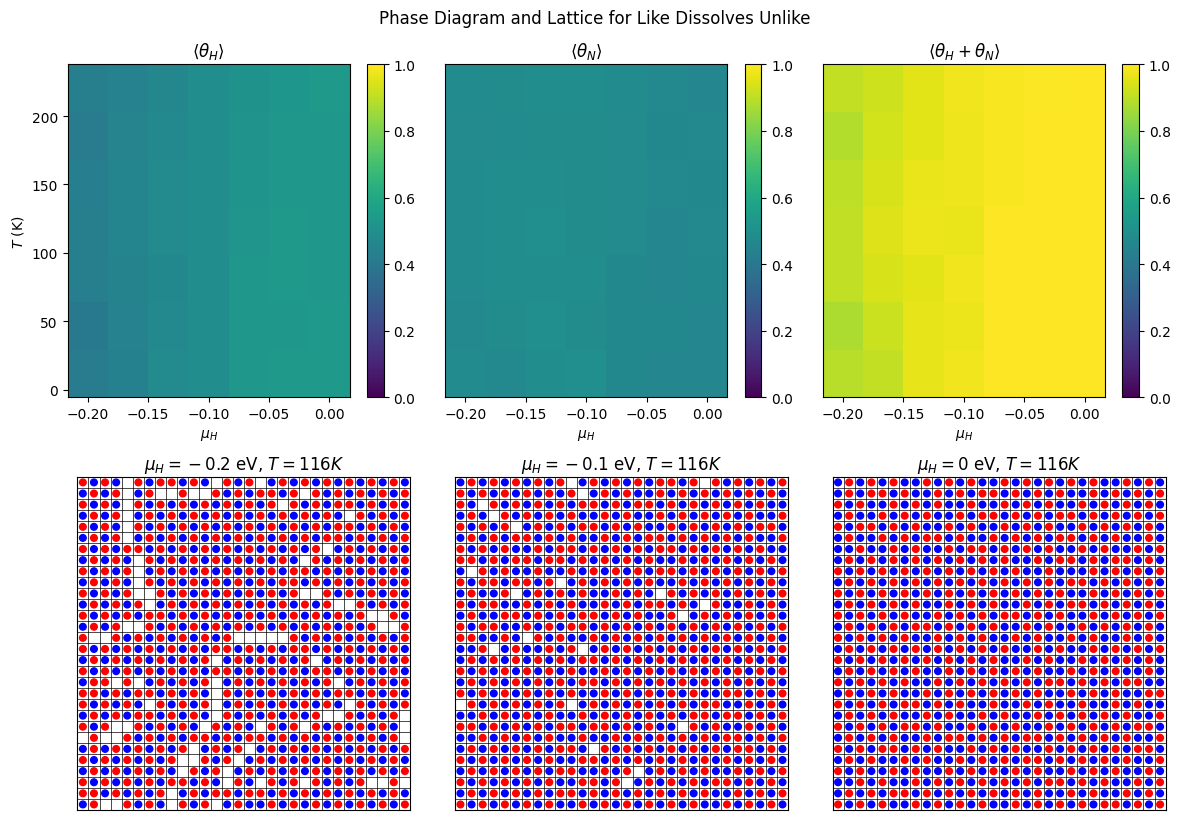

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
lattice_size = 30  # Lattice size (NxN)
n_steps = 10000
mus_H = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

# Convert T values to Kelvin (assuming T in eV/k_B, where k_B = 8.6173e-5 eV/K)
k_B = 8.6173e-5
Ts_kelvin = Ts / k_B

# Interaction parameters (eV)
interaction_sets = {
    "Ideal Mixture": [-0.1, -0.1, 0.0, 0.0, 0.0],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Repulsive Interactions": [-0.1, -0.1, 0.05, 0.05, 0.05],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Attractive Interactions": [-0.1, -0.1, -0.05, -0.05, -0.05],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Immiscible": [-0.1, -0.1, -0.05, -0.05, 0.05],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
    "Like Dissolves Unlike": [-0.1, -0.1, 0.05, 0.05, -0.05]  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH
}

# Function to initialize lattice
def initialize_lattice(size):
    lattice = np.zeros((size, size))  # 0 represents empty sites
    return lattice

# Testing snippet for lattice initialization
def test_initialize_lattice():
    lattice = initialize_lattice(5)
    assert lattice.shape == (5, 5), "Lattice size is incorrect"
    assert np.all(lattice == 0), "Lattice is not properly initialized with empty sites"
    print("test_initialize_lattice passed.")

# Function to compute neighbor indices
def compute_neighbor_indices(size):
    neighbor_indices = {}
    for x in range(size):
        for y in range(size):
            neighbors = [
                ((x - 1) % size, y),
                ((x + 1) % size, y),
                (x, (y - 1) % size),
                (x, (y + 1) % size)
            ]
            neighbor_indices[(x, y)] = neighbors
    return neighbor_indices

# Testing snippet for neighbor calculation
def test_compute_neighbor_indices():
    neighbor_indices = compute_neighbor_indices(3)
    assert len(neighbor_indices) == 9, "Neighbor indices dictionary size is incorrect"
    assert neighbor_indices[(0, 0)] == [(2, 0), (1, 0), (0, 2), (0, 1)], "Neighbor indices calculation is incorrect"
    print("test_compute_neighbor_indices passed.")

# Function to calculate interaction energy
def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_HH, epsilon_NN, epsilon_NH):
    x, y = site
    interaction_energy = 0
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        if neighbor_particle != 0:
            if particle == 1:  # Particle H
                if neighbor_particle == 1:
                    interaction_energy += epsilon_HH
                else:
                    interaction_energy += epsilon_NH
            else:  # Particle H
                if neighbor_particle == 2:
                    interaction_energy += epsilon_NN
                else:
                    interaction_energy += epsilon_NH
    return interaction_energy

# Testing snippet for interaction energy calculation
def test_calculate_interaction_energy():
    lattice = np.array([[1, 0, 2], [0, 1, 0], [2, 0, 0]])
    neighbor_indices = compute_neighbor_indices(3)
    epsilon_NN, epsilon_HH, epsilon_NH = -0.05, -0.05, 0.05
    
    # Calculate expected energy manually
    # The central particle (1, 1) is of type N (1)
    # It has neighbors at (0, 1), (2, 1), (1, 0), (1, 2)
    # Neighbors: (0, 1) is empty, (2, 1) is empty, (1, 0) is empty, (1, 2) is empty
    # Only non-zero neighbors are at (0, 0) and (2, 0), which are types 1 and 2 respectively
    expected_energy = epsilon_NN + epsilon_NH  # -0.05 + 0.05 = 0.0
    
    energy = calculate_interaction_energy(lattice, (1, 1), 1, neighbor_indices, epsilon_NN, epsilon_HH, epsilon_NH)
    print(f"Calculated energy: {energy}, Expected energy: {expected_energy}")
    assert np.isclose(energy, expected_energy), "Interaction energy calculation is incorrect"
    print("test_calculate_interaction_energy passed.")

# Function to attempt a Monte Carlo move
def attempt_move(lattice, N_H, N_N, H_empty, neighbor_indices, params):
    size = lattice.shape[0]
    H_sites = size * size
    beta = 1 / params['T']
    epsilon_H, epsilon_N, epsilon_HH, epsilon_NN, epsilon_NH, mu_H, mu_N = (
        params['epsilon_H'], params['epsilon_N'], params['epsilon_HH'],
        params['epsilon_NN'], params['epsilon_NH'], params['mu_H'], params['mu_N']
    )

    if random.random() < 0.5:  # Attempt to add a particle
        if H_empty == 0:
            return N_H, N_N, H_empty
        site = random.choice(np.argwhere(lattice == 0))
        particle = random.choice([1, 2])
        if particle == 1:
            mu = mu_H
            epsilon = epsilon_H
            N_s = N_H
        else:
            mu = mu_N
            epsilon = epsilon_N
            N_s = N_N
        delta_E = epsilon + calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_HH, epsilon_NN, epsilon_NH)
        acc_prob = min(1, (H_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = particle
            if particle == 1:
                N_H += 1
            else:
                N_N += 1
            H_empty -= 1
    else:  # Removing a particle
        if H_sites - H_empty == 0:
            return N_H, N_N, H_empty
        site = random.choice(np.argwhere(lattice != 0))
        particle = lattice[tuple(site)]
        if particle == 1:
            mu = mu_H
            epsilon = epsilon_H
            N_s = N_H
        else:
            mu = mu_N
            epsilon = epsilon_N
            N_s = N_N
        delta_E = -epsilon - calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_HH, epsilon_NN, epsilon_NH)
        acc_prob = min(1, (N_s / (H_empty + 1)) * np.exp(-beta * (delta_E + mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = 0
            if particle == 1:
                N_H -= 1
            else:
                N_N -= 1
            H_empty += 1
    return N_H, N_N, H_empty

# Testing snippet for Monte Carlo move attempt
def test_attempt_move():
    lattice = initialize_lattice(3)
    neighbor_indices = compute_neighbor_indices(3)
    params = {
        'epsilon_N': -0.1, 'epsilon_H': -0.1, 'epsilon_NN': 0.0,
        'epsilon_HH': 0.0, 'epsilon_NH': 0.0, 'mu_N': -0.05, 'mu_H': -0.05, 'T': 0.01
    }
    N_N, N_H, N_empty = 0, 0, 9
    N_N, N_H, N_empty = attempt_move(lattice, N_N, N_H, N_empty, neighbor_indices, params)
    assert N_N + N_H + N_empty == 9, "Total number of lattice sites changed incorrectly"
    print("test_attempt_move passed.")

# Run all tests
test_initialize_lattice()
test_compute_neighbor_indices()
test_calculate_interaction_energy()
test_attempt_move()

# Function to run the simulation
def run_simulation(size, n_steps, params):
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    H_sites = size * size
    N_H, N_N, H_empty = 0, 0, H_sites
    coverage_H = np.zeros(n_steps)
    coverage_N = np.zeros(n_steps)

    for step in range(n_steps):
        N_H, N_N, H_empty = attempt_move(lattice, N_H, N_N, H_empty, neighbor_indices, params)
        coverage_H[step] = N_H / H_sites
        coverage_N[step] = N_N / H_sites

    return lattice, coverage_H, coverage_N

# Function to plot lattice configuration
def plot_lattice(ax, lattice, title):
    size = lattice.shape[0]
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    # Plot lattice as circles
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1:
                ax.add_patch(plt.Circle((y, x), 0.3, color='blue'))
            elif lattice[x, y] == 2:
                ax.add_patch(plt.Circle((y, x), 0.3, color='red'))
    # Add grid lines
    for x in range(size + 1):
        ax.plot([x - 0.5, x - 0.5], [-0.5, size - 0.5], color='black', lw=0.5)
    for y in range(size + 1):
        ax.plot([-0.5, size - 0.5], [y - 0.5, y - 0.5], color='black', lw=0.5)
    ax.set_xlim(-0.5, size - 0.5)
    ax.set_ylim(-0.5, size - 0.5)
    ax.set_aspect('equal')

# Run the simulation
np.random.seed(42)

final_lattice = np.zeros((len(mus_H), len(Ts), lattice_size, lattice_size))
mean_coverage_H = np.zeros((len(mus_H), len(Ts)))
mean_coverage_N = np.zeros((len(mus_H), len(Ts)))

for interaction_name, interaction_params in interaction_sets.items():
    for i, mu_H in enumerate(mus_H):
        for j, T in enumerate(Ts):
            params = {
                'epsilon_H': interaction_params[0],
                'epsilon_N': interaction_params[1],
                'epsilon_HH': interaction_params[2],
                'epsilon_NN': interaction_params[3],
                'epsilon_NH': interaction_params[4],
                'mu_H': mu_H,
                'mu_N': -0.1,
                'T': T
            }
            lattice, coverage_H, coverage_N = run_simulation(lattice_size, n_steps, params)
            final_lattice[i, j] = lattice
            mean_coverage_H[i, j] = np.mean(coverage_H[-1000:])
            mean_coverage_N[i, j] = np.mean(coverage_N[-1000:])

    # Plot the T-mu_H phase diagram
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.ravel()

    # Mean coverage of H
    cax1 = axs[0].pcolormesh(mus_H, Ts_kelvin, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title(r'$\langle \theta_H \rangle$')
    axs[0].set_xlabel(r'$\mu_H$')
    axs[0].set_ylabel(r'$T$ (K)')
    fig.colorbar(cax1, ax=axs[0])

    # Mean coverage of N
    cax2 = axs[1].pcolormesh(mus_H, Ts_kelvin, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title(r'$\langle \theta_N \rangle$')
    axs[1].set_xlabel(r'$\mu_H$')
    axs[1].set_yticks([])
    fig.colorbar(cax2, ax=axs[1])

    # Mean total coverage
    cax3 = axs[2].pcolormesh(mus_H, Ts_kelvin, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
    axs[2].set_xlabel(r'$\mu_H$')
    axs[2].set_yticks([])
    fig.colorbar(cax3, ax=axs[2])

    # Plot the final lattice configuration as circles
    plot_indices = [(0, 3), (3, 3), (6, 3)]  # (mu_H index, T index)
    plot_titles = [r'$\mu_H = -0.2$ eV, $T = 116 K$', r'$\mu_H = -0.1$ eV, $T = 116 K$', r'$\mu_H = 0$ eV, $T = 116 K$']

    for idx, (mu_idx, T_idx) in enumerate(plot_indices):
        ax = axs[3 + idx]
        lattice_plot = final_lattice[mu_idx, T_idx]
        plot_lattice(ax, lattice_plot, plot_titles[idx])

    plt.tight_layout()
    plt.suptitle(f"Phase Diagram and Lattice for {interaction_name}", y=1.02)
    plt.show()